## Research Ethics
This code makes use of the mitdeeplearning package (Amini, 2024) and trains a DB-VAE
inspired by the Debiasing Computer Vision Lab notebook from 6.S191.

### Copyright 2024 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved. 
 
Licensed under the MIT License. You may not use this file except in compliance 
with the License. Use and/or modification of this code outside of 6.S191 must 
reference: 

© MIT 6.S191: Introduction to Deep Learning 
http://introtodeeplearning.com 

In [1]:
### Imports & Comet Setup ###
COMET_API_KEY = "t6Sqtes2FLSBv39Opo3q8TmVk"
import comet_ml

### Create a Comet experiment to track our training run ###
def create_experiment(project_name, params):
    # end any prior experiments
    if 'experiment' in locals():
        experiment.end()

    # initiate the comet experiment for tracking
    experiment = comet_ml.Experiment(
    api_key=COMET_API_KEY,
    project_name=project_name)
    # log our hyperparameters, defined above, to the experiment
    for param, value in params.items():
        experiment.log_parameter(param, value)
    experiment.flush()

    return experiment

import os
CWD = os.getcwd()
print(CWD)

### Data Visualization ###
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = "Times New Roman"

### Data Loading ###
import h5py
import mitdeeplearning as mdl

### The Rest ###
import numpy as np 
import pandas as pd 
import tensorflow as tf 
from tensorflow import keras
from keras import backend, layers, utils
import functools

assert len(tf.config.list_physical_devices('GPU')) > 0
assert COMET_API_KEY != "", "Please insert your Comet API Key"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

/mnt/e/ap_research


2024-02-14 22:01:14.334521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 22:01:14.334611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 22:01:14.584682: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-14 22:01:14.790078: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-14 22:01:20.723933: I external/local_xla/xla/

# Create our Standard ResNet50V2 CNN

In [2]:
### Standard CNN ###

# Helper Functions
def resize_images(x):
    return tf.image.resize(x, (64, 64))

# CNN Function
def make_standard_ResNet50_V2(n_outputs = 1):
    
    Resize = tf.keras.layers.Lambda(resize_images)
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
    ResNet50V2 = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights="imagenet", # Utilizing Transfer Learning, also maintains consistency
        input_tensor=None,
        input_shape=(64,64,3),
        pooling=None,
        classes=1000,
        classifier_activation="softmax",
    )
    ResNet50V2 = tf.keras.Model(inputs = ResNet50V2.layers[1].input, 
                                outputs = ResNet50V2.layers[-1].output)

    model = tf.keras.Sequential()
    
    model.add(Resize)
    model.add(ResNet50V2)
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(n_outputs, activation=None))

    return model

# Create our DB-VAE

In [3]:
### Define Decoder Network ###
latent_dim = 100 # number of latent variables
n_filters = 12 
def make_decoder_network():
    """
    Layer Types, Functional Definition
    """
    Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
    Reshape = tf.keras.layers.Reshape 
    BatchNormalization = tf.keras.layers.BatchNormalization
    LeakyReLU = tf.keras.layers.LeakyReLU
    # Decoder
    decoder = tf.keras.Sequential([
        Dense(units=4*4*6*n_filters),
        Reshape(target_shape=(4,4,6*n_filters)),

        Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='sigmoid')
    ])
    
    return decoder

In [4]:
### DB_VAE Helper Functions ###

### VAE Reparameterization ###
def sampling(z_mean, z_logsigma):
    batch, latent_dim = z_mean.shape
    epsilon = tf.random.normal(shape=(batch, latent_dim))
    z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
    return z

### Defining the VAE loss function ###
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  return vae_loss

### Loss function for DB-VAE ###
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  malignance_indicator = tf.cast(tf.equal(y, 1), tf.float32)
  total_loss = tf.reduce_mean(
      classification_loss +
      malignance_indicator * vae_loss
  )
  return total_loss, classification_loss

In [5]:
### Defining and creating the DB-VAE ###

class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have
    # `latent_dim` latent variables, as well as a supervised output for the
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_ResNet50_V2(num_encoder_dims)
    self.decoder = make_decoder_network()

  def encode(self, x):
    encoder_output = self.encoder(x)
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    z_mean = encoder_output[:, 1:self.latent_dim+1]
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  def reparameterize(self, z_mean, z_logsigma):
    z = sampling(z_mean, z_logsigma)
    return z

  def decode(self, z):
    reconstruction = self.decoder(z)
    return reconstruction

  def call(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    z = self.reparameterize(z_mean, z_logsigma)
    recon = self.decode(z)
    return y_logit, z_mean, z_logsigma, recon

  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

dbvae = DB_VAE(latent_dim)

2024-02-14 22:01:21.202010: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 22:01:21.202090: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 22:01:21.202119: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 22:01:21.728297: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 22:01:21.728368: I external/local_xla/xla/stream_executor

## ISIC Data Loading

Keys: ['images', 'labels']
Dataset: images
  Shape: (1976, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (1976, 1)
  Data type: uint8
Opening /mnt/e/ap_research/datasets/ISIC/ISIC.h5
Loading data into memory...
1976


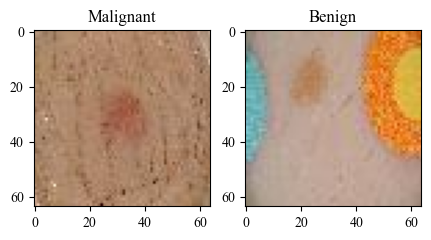

In [6]:
### Examine Dataset ###
with h5py.File(f'{CWD}/datasets/ISIC/ISIC.h5','r') as f:
    # Print the keys (names) of all groups and datasets in the file
    print("Keys:", list(f.keys()))

    # Iterate through each key and print more detailed information
    for key in f.keys():
        if isinstance(f[key], h5py.Dataset):
            print(f"Dataset: {key}")
            print("  Shape:", f[key].shape)
            print("  Data type:", f[key].dtype)

### Instantiate Loader Function ###
path_to_training_data= f'{CWD}/datasets/ISIC/ISIC.h5'
loader_ISIC = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

### Visualize our data ###
number_of_training_examples = loader_ISIC.get_train_size()
print(number_of_training_examples)
(images, labels) = loader_ISIC.get_batch(100)
malignant_images = images[np.where(labels==1)[0]]
benign_images = images[np.where(labels==0)[0]]

idx_malignant = 23
idx_benign = 9

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(malignant_images[idx_malignant])
plt.title("Malignant"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(benign_images[idx_benign])
plt.title("Benign"); plt.grid(False)

## ISIC_DiDI Data Loading

Keys: ['images', 'labels']
Dataset: images
  Shape: (2632, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (2632, 1)
  Data type: uint8
Opening /mnt/e/ap_research/datasets/ISIC_DiDI/ISIC_DiDI.h5
Loading data into memory...
2632


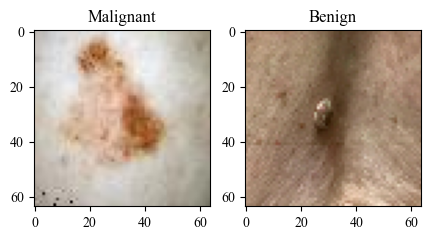

In [13]:
### Examine Dataset ###
with h5py.File(f'{CWD}/datasets/ISIC_DiDI/ISIC_DiDI.h5','r') as f:
    # Print the keys (names) of all groups and datasets in the file
    print("Keys:", list(f.keys()))

    # Iterate through each key and print more detailed information
    for key in f.keys():
        if isinstance(f[key], h5py.Dataset):
            print(f"Dataset: {key}")
            print("  Shape:", f[key].shape)
            print("  Data type:", f[key].dtype)

### Instantiate Loader Function ###
path_to_training_data= f'{CWD}/datasets/ISIC_DiDI/ISIC_DiDI.h5'
loader_ISIC_DiDI = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

### Visualize our data ###
number_of_training_examples = loader_ISIC_DiDI.get_train_size()
print(number_of_training_examples)
(images, labels) = loader_ISIC_DiDI.get_batch(100)
malignant_images = images[np.where(labels==1)[0]]
benign_images = images[np.where(labels==0)[0]]

idx_malignant = 23
idx_benign = 9

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(malignant_images[idx_malignant])
plt.title("Malignant"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(benign_images[idx_benign])
plt.title("Benign"); plt.grid(False)

## ISIC_ArGI Data Loading

Keys: ['images', 'labels']
Dataset: images
  Shape: (2632, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (2632, 1)
  Data type: uint8
Opening /mnt/e/ap_research/datasets/ISIC_ArGI/ISIC_ArGI.h5
Loading data into memory...
2632


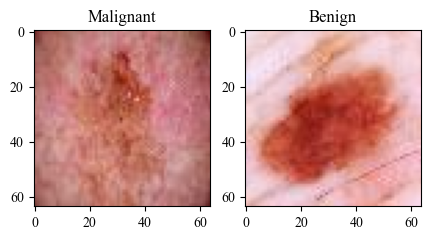

In [15]:
### Examine Dataset ###
with h5py.File(f'{CWD}/datasets/ISIC_ArGI/ISIC_ArGI.h5','r') as f:
    # Print the keys (names) of all groups and datasets in the file
    print("Keys:", list(f.keys()))

    # Iterate through each key and print more detailed information
    for key in f.keys():
        if isinstance(f[key], h5py.Dataset):
            print(f"Dataset: {key}")
            print("  Shape:", f[key].shape)
            print("  Data type:", f[key].dtype)

### Instantiate Loader Function ###
path_to_training_data= f'{CWD}/datasets/ISIC_ArGI/ISIC_ArGI.h5'
loader_ISIC_ArGI = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

### Visualize our data ###
number_of_training_examples = loader_ISIC_DiDI.get_train_size()
print(number_of_training_examples)
(images, labels) = loader_ISIC_ArGI.get_batch(100)
malignant_images = images[np.where(labels==1)[0]]
benign_images = images[np.where(labels==0)[0]]

idx_malignant = 23
idx_benign = 9

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(malignant_images[idx_malignant])
plt.title("Malignant"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(benign_images[idx_benign])
plt.title("Benign"); plt.grid(False)

# Model 1 - Standard ResNet50V2, trained on ISIC alone.

In [9]:
model_1 = make_standard_ResNet50_V2()

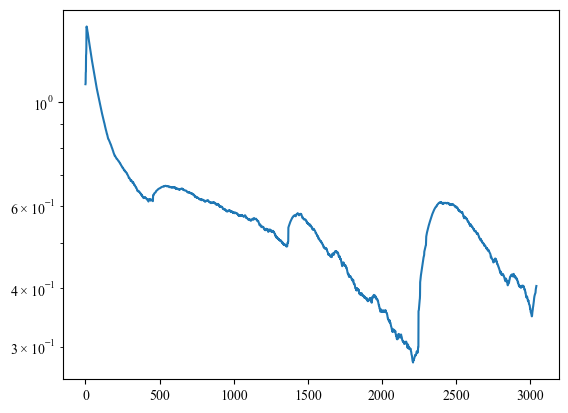

100%|██████████| 61/61 [00:05<00:00, 11.28it/s]


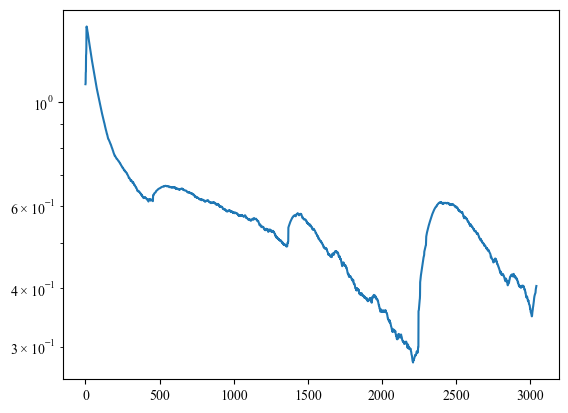

In [10]:
### Train the standard CNN ###

# Training hyperparameters
params = dict(
  batch_size = 32,
  num_epochs = 50,  # keep small to run faster
  learning_rate = 5e-4,
)

experiment = create_experiment("Model_1", params)

optimizer = tf.keras.optimizers.Adam(params["learning_rate"]) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = model_1(x)
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, model_1.trainable_variables)
  optimizer.apply_gradients(zip(grads, model_1.trainable_variables))
  return loss

# The training loop!
step = 0
for epoch in range(params["num_epochs"]):
  for idx in tqdm(range(loader_ISIC.get_train_size()//params["batch_size"])):
    # Grab a batch of training data and propagate through the network
    x, y = loader_ISIC.get_batch(params["batch_size"])

    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

    experiment.log_metric("loss", loss.numpy().mean(), step=step)
    step += 1

In [11]:
### Obtain Loss Values Over Epoch ###
steps = len(loss_history.get())
print(steps)

epochs = np.uint8(params['num_epochs'])
batches_per_epoch = np.uint8(steps/epochs)

loss_hist = np.zeros((steps,1))
for i in range(steps):
    loss_hist[i] = loss_history.get()[i]
loss_hist = loss_hist.reshape(epochs, batches_per_epoch)

row_means = np.zeros((epochs))
for i in range(epochs):
    row_means[i] = loss_hist.sum(axis=1)[i]

row_means = row_means/batches_per_epoch
for mean in row_means:
    print(mean)

3050
1.2836106640381824
1.0207627277019804
0.8475306676307625
0.7580234392744604
0.7072138325509445
0.6620614216663798
0.627213571146563
0.6309522717769639
0.6588045194185446
0.6590089614899984
0.6522196811284289
0.6413637734336303
0.6241435015203585
0.6141944117282956
0.6058166512085724
0.5897125159218513
0.5801711461150973
0.5704521525024309
0.5620052429603509
0.5439334190240562
0.5306547965675408
0.5071440890448902
0.5301940294374049
0.5745968888654801
0.5548156653841246
0.5242509717046775
0.4881285287621766
0.474395588873184
0.452705112615701
0.4158544161682654
0.3896694124382613
0.38000928496954217
0.36834793598022997
0.3441443268733055
0.3185393481442269
0.3034203503860315
0.3009560184261823
0.4810036966314663
0.582174260150161
0.609349719067694
0.6044792985671897
0.5828944964735697
0.5504327693177649
0.5170024720945628
0.4826351201414159
0.45036675927586983
0.41924446415726313
0.42092045425404634
0.39559777133639595
0.3761021400268325


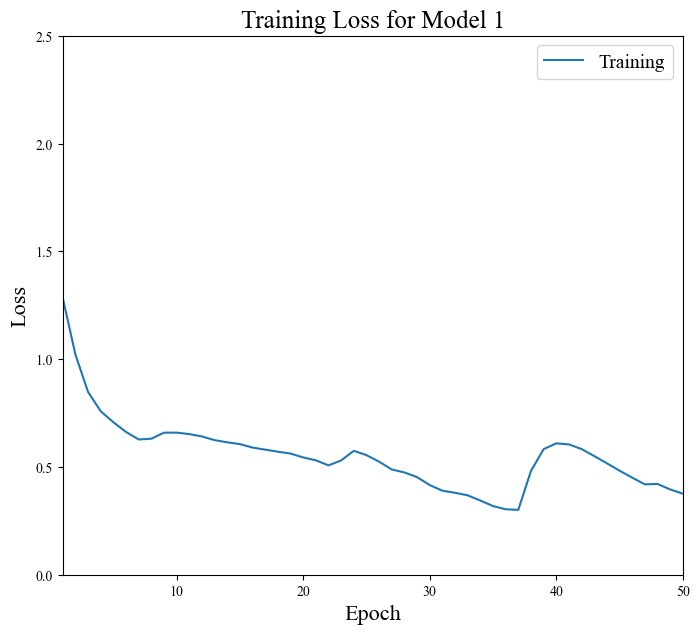

In [12]:
# Graph Loss
import matplotlib
matplotlib.rcParams['font.family'] = "Times New Roman"
epochs_range = np.arange(1,51)
plt.figure(figsize=(8,7))
size_axis_titles = 16
size_title = 18
size_legend = 14
plt.xlabel("Epoch", fontsize=size_axis_titles)
plt.ylabel("Loss", fontsize = size_axis_titles)
plt.axis([1, 50, 0, 2.5])
plt.plot(epochs_range,row_means,label='Training')
plt.legend(loc='upper right', fontsize=size_legend)
plt.title(f'Training Loss for Model 1', fontsize=size_title)
plt.show()

In [13]:
### Evaluation of standard CNN on ISIC ###
n=30
accuracies = np.zeros((n,1))
for i in range(n):
    (batch_x, batch_y) = loader_ISIC.get_batch(256) # Matches batch size
    y_pred_standard = tf.round(tf.nn.sigmoid(model_1.predict(batch_x)))
    acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
    accuracies[i] = acc_standard.numpy()

print(accuracies.mean())
print(accuracies.std())

8/8 [==============================] - 0s 18ms/step
0.7037760416666666
0.021774399752737473


In [14]:
### Evaluation of standard CNN on ISIC_DiDI ###
n=30
accuracies = np.zeros((n,1))

for i in range(n):
    (batch_x, batch_y) = loader_ISIC_DiDI.get_batch(256) # Matches batch size
    y_pred_standard = tf.round(tf.nn.sigmoid(model_1.predict(batch_x)))
    acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
    accuracies[i] = acc_standard.numpy()

print(accuracies.mean())
print(accuracies.std())

8/8 [==============================] - 0s 16ms/step
0.6481770833333333
0.025474287911893743


In [15]:
### Clear Previous Session ###
tf.keras.backend.clear_session()
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/model-1/3692d9b3dbab46fd8a531a7da1aa0d9d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [3050] : (0.04732045903801918, 15.000828742980957)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INFO:     Adam_epsilon                 : 1e-07
COMET INFO:     Adam_global_

# Model 2 - Standard ResNet50V2, trained on ISIC_DiDI.

In [16]:
model_2 = make_standard_ResNet50_V2()

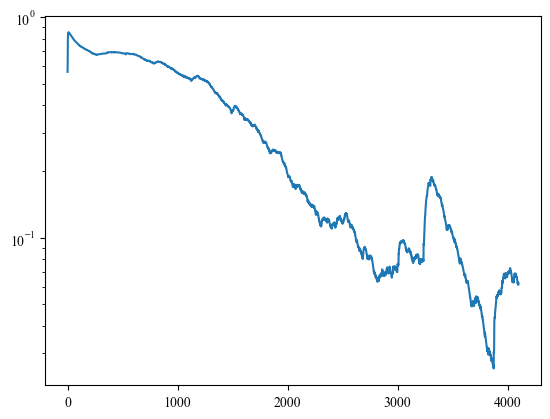

100%|██████████| 82/82 [00:07<00:00, 10.42it/s]


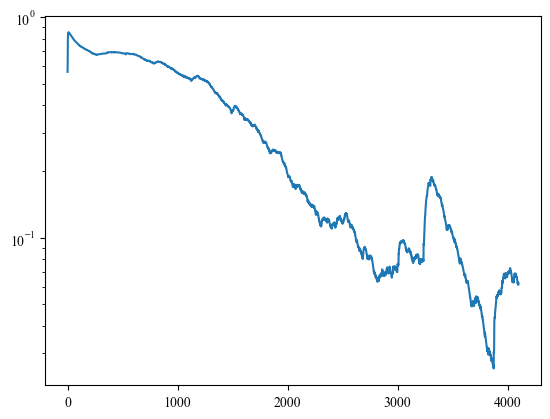

In [17]:
### Train the standard CNN ###

# Training hyperparameters
params = dict(
  batch_size = 32,
  num_epochs = 50,  # keep small to run faster
  learning_rate = 5e-4,
)

experiment = create_experiment("Model_2", params)

optimizer = tf.keras.optimizers.Adam(params["learning_rate"]) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = model_2(x)
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, model_2.trainable_variables)
  optimizer.apply_gradients(zip(grads, model_2.trainable_variables))
  return loss

# The training loop!
step = 0
for epoch in range(params["num_epochs"]):
  for idx in tqdm(range(loader_ISIC_DiDI.get_train_size()//params["batch_size"])):
    # Grab a batch of training data and propagate through the network
    x, y = loader_ISIC_DiDI.get_batch(params["batch_size"])

    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

    experiment.log_metric("loss", loss.numpy().mean(), step=step)
    step += 1

In [18]:
### Obtain Loss Values Over Epoch ###
steps = len(loss_history.get())
print(steps)

epochs = np.uint8(params['num_epochs'])
batches_per_epoch = np.uint8(steps/epochs)

loss_hist = np.zeros((steps,1))
for i in range(steps):
    loss_hist[i] = loss_history.get()[i]
loss_hist = loss_hist.reshape(epochs, batches_per_epoch)

row_means = np.zeros((epochs))
for i in range(epochs):
    row_means[i] = loss_hist.sum(axis=1)[i]

row_means = row_means/batches_per_epoch
for mean in row_means:
    print(mean)

4100
0.805707405634957
0.7388434227104571
0.6982752062369011
0.6804167416358995
0.6910099133910357
0.6928346766825992
0.6850470328465021
0.6761172367925617
0.6467067876074167
0.6256169488655616
0.6200197236348052
0.5867224325108629
0.5510505688029105
0.5286226490065289
0.5329083929436519
0.5067204149258557
0.45358952973096844
0.40579868516937084
0.3844522061253689
0.35594429069987504
0.3267240422012892
0.2870844933623547
0.2512247559765732
0.23826330623484407
0.1933827459483616
0.17002401665398026
0.1524094075042881
0.13184808060442973
0.11966442019594782
0.11556722503404526
0.12260486673691502
0.11213760974852129
0.088844001540511
0.08101256104851845
0.06713889575986193
0.07007388684368135
0.07853127541783689
0.09146850866692069
0.08150144928046285
0.10928206598378441
0.17595417248671785
0.14045649113126213
0.10657568314164818
0.080804201396449
0.05820666364258303
0.050158783081685226
0.033733107019278674
0.044900341695345215
0.06567702385819005
0.06646268369361409


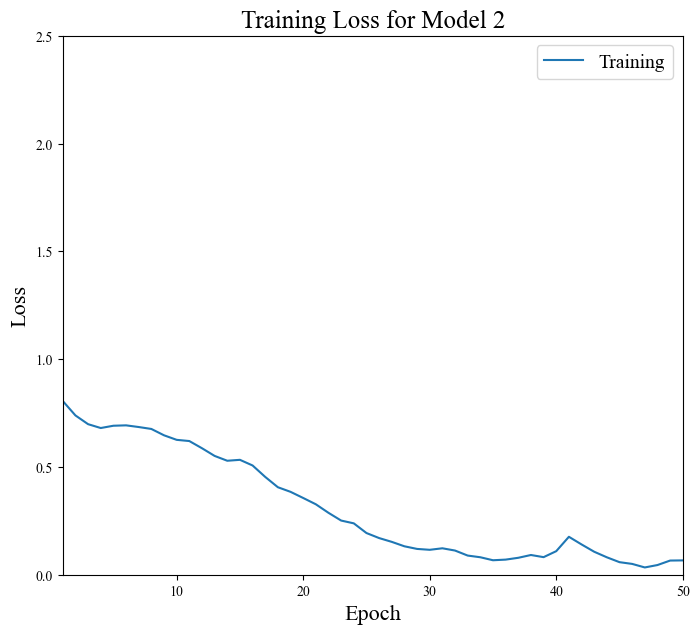

In [19]:
### Graph Loss ###
import matplotlib
matplotlib.rcParams['font.family'] = "Times New Roman"
epochs_range = np.arange(1,51)
plt.figure(figsize=(8,7))
size_axis_titles = 16
size_title = 18
size_legend = 14
plt.xlabel("Epoch", fontsize=size_axis_titles)
plt.ylabel("Loss", fontsize = size_axis_titles)
plt.axis([1, 50, 0, 2.5])
plt.plot(epochs_range,row_means,label='Training')
plt.legend(loc='upper right', fontsize=size_legend)
plt.title(f'Training Loss for Model 2', fontsize=size_title)
plt.show()

In [20]:
### Evaluation of standard CNN on ISIC ###
n=30
accuracies = np.zeros((n,1))

for i in range(n):
    (batch_x, batch_y) = loader_ISIC.get_batch(256) # Matches batch size
    y_pred_standard = tf.round(tf.nn.sigmoid(model_2.predict(batch_x)))
    acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
    accuracies[i] = acc_standard.numpy()

print(accuracies.mean())
print(accuracies.std())

8/8 [==============================] - 0s 16ms/step
0.9796875
0.00764135455787563


In [21]:
### Evaluation of standard CNN on ISIC_DiDI ###
n=30
accuracies = np.zeros((n,1))

for i in range(n):
    (batch_x, batch_y) = loader_ISIC_DiDI.get_batch(256) # Matches batch size
    y_pred_standard = tf.round(tf.nn.sigmoid(model_2.predict(batch_x)))
    acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
    accuracies[i] = acc_standard.numpy()

print(accuracies.mean())
print(accuracies.std())

8/8 [==============================] - 0s 16ms/step
0.979296875
0.008626240664089523


In [22]:
### Clear Previous Session ###
tf.keras.backend.clear_session()
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/model-2/0b26255e384044e39a67f255681ab302
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [4100] : (2.9718059522565454e-05, 20.84081268310547)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INFO:     Adam_epsilon                 : 1e-07
COMET INFO:     Adam_globa

# Model 3

In [23]:
model_3 = make_standard_ResNet50_V2()

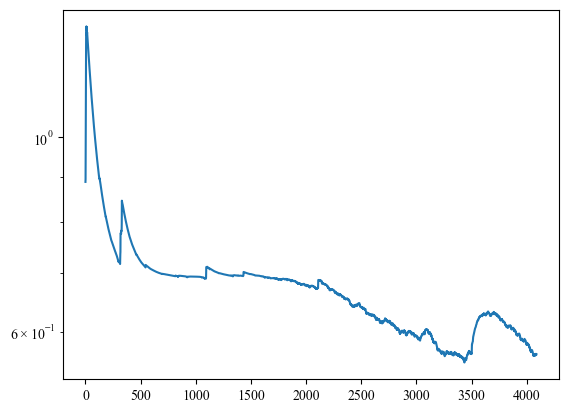

100%|██████████| 82/82 [00:07<00:00, 11.46it/s]


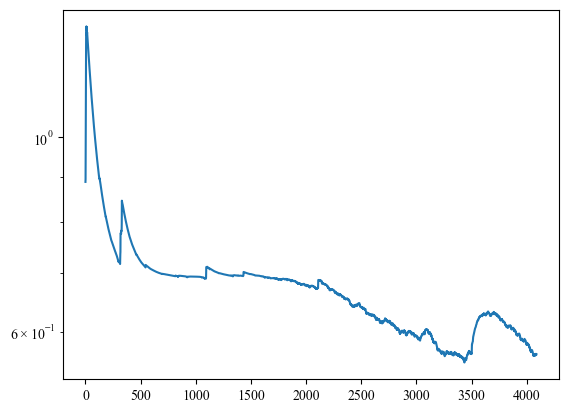

In [24]:
### Train the standard CNN ###

# Training hyperparameters
params = dict(
  batch_size = 32,
  num_epochs = 50,  # keep small to run faster
  learning_rate = 5e-4,
)

experiment = create_experiment("Model_3", params)

optimizer = tf.keras.optimizers.Adam(params["learning_rate"]) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = model_3(x)
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, model_3.trainable_variables)
  optimizer.apply_gradients(zip(grads, model_3.trainable_variables))
  return loss

# The training loop!
step = 0
for epoch in range(params["num_epochs"]):
  for idx in tqdm(range(loader_ISIC_ArGI.get_train_size()//params["batch_size"])):
    # Grab a batch of training data and propagate through the network
    x, y = loader_ISIC_ArGI.get_batch(params["batch_size"])

    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

    experiment.log_metric("loss", loss.numpy().mean(), step=step)
    step += 1

In [25]:
### Obtain Loss Values Over Epoch ###
steps = len(loss_history.get())
print(steps)

epochs = np.uint8(params['num_epochs'])
batches_per_epoch = np.uint8(steps/epochs)

loss_hist = np.zeros((steps,1))
for i in range(steps):
    loss_hist[i] = loss_history.get()[i]
loss_hist = loss_hist.reshape(epochs, batches_per_epoch)

row_means = np.zeros((epochs))
for i in range(epochs):
    row_means[i] = loss_hist.sum(axis=1)[i]

row_means = row_means/batches_per_epoch
for mean in row_means:
    print(mean)

4100
1.1620343729449938
0.9131301785049933
0.7918680982271858
0.7401558325446502
0.8004429069970498
0.7413048737407153
0.7154279855947394
0.7050752277207769
0.6986470711634237
0.6955036378558181
0.6945351515154405
0.6933847802352047
0.6929244602608291
0.702572644933273
0.7016860897688677
0.6968564630793797
0.6953538541098604
0.6977705592430524
0.6969835655179325
0.6938199510556242
0.6909541543254333
0.6888982895760704
0.6875078891144606
0.6821824522819259
0.6774954717346923
0.6777290620636918
0.6786947859572682
0.6669634857413649
0.6571675994169173
0.6449916669464867
0.6406571800505266
0.627846068154446
0.6179826901749034
0.6159930619714739
0.6040921154113553
0.5993097661096857
0.593187131896011
0.598056227442566
0.5859926841634616
0.5683088425851219
0.5667227581332086
0.5616116890270066
0.5724059359991056
0.6190420945567711
0.6286734382882213
0.6257228792571371
0.6118171021184107
0.6005039023612744
0.5853726279327343
0.5680039902309792


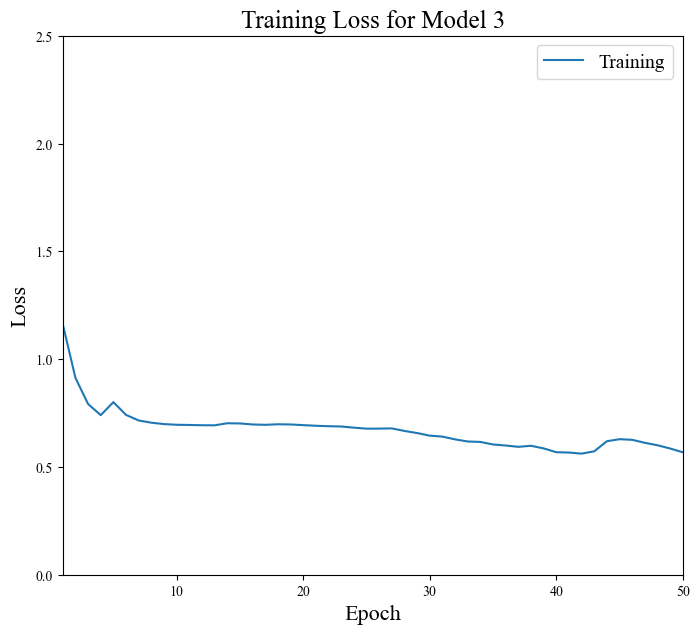

In [26]:
### Graph Loss ###
import matplotlib
matplotlib.rcParams['font.family'] = "Times New Roman"
epochs_range = np.arange(1,51)
plt.figure(figsize=(8,7))
size_axis_titles = 16
size_title = 18
size_legend = 14
plt.xlabel("Epoch", fontsize=size_axis_titles)
plt.ylabel("Loss", fontsize = size_axis_titles)
plt.axis([1, 50, 0, 2.5])
plt.plot(epochs_range,row_means,label='Training')
plt.legend(loc='upper right', fontsize=size_legend)
plt.title(f'Training Loss for Model 3', fontsize=size_title)
plt.show()

In [27]:
### Evaluation of standard CNN on ISIC ###
n=30
accuracies = np.zeros((n,1))

for i in range(n):
    (batch_x, batch_y) = loader_ISIC.get_batch(256) # Matches batch size
    y_pred_standard = tf.round(tf.nn.sigmoid(model_3.predict(batch_x)))
    acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
    accuracies[i] = acc_standard.numpy()

print(accuracies.mean())
print(accuracies.std())

8/8 [==============================] - 0s 15ms/step
0.738671875
0.027920808247669425


In [28]:
### Evaluation of standard CNN on ISIC_DiDI ###
n=30
accuracies = np.zeros((n,1))

for i in range(n):
    (batch_x, batch_y) = loader_ISIC_DiDI.get_batch(256) # Matches batch size
    y_pred_standard = tf.round(tf.nn.sigmoid(model_3.predict(batch_x)))
    acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
    accuracies[i] = acc_standard.numpy()

print(accuracies.mean())
print(accuracies.std())

8/8 [==============================] - 0s 17ms/step
0.6803385416666666
0.02875953995177682


# Models 4, 5, and 6
Between training different models, make sure to rerun the initialization code below to reset the weights of the dbvae.


In [20]:
dbvae = DB_VAE(latent_dim)

In [8]:
### DB_VAE Training Helper Functions ###

# Function to return the means for an input image batch
def get_latent_mu(images, dbvae, batch_size=1024):
    N = images.shape[0]
    mu = np.zeros((N, latent_dim))
    for start_ind in range(0, N, batch_size):
        end_ind = min(start_ind+batch_size, N+1)
        batch = (images[start_ind:end_ind]).astype(np.float32)/255.
        _, batch_mu, _ = dbvae.encode(batch)
        mu[start_ind:end_ind] = batch_mu
    return mu

def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001):
    print("Recomputing the sampling probabilities")
    mu = get_latent_mu(images, dbvae)
    training_sample_p = np.zeros(mu.shape[0])
    for i in range(latent_dim):
        latent_distribution = mu[:,i]
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        bin_idx = np.digitize(latent_distribution, bin_edges)
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        p = p / np.sum(p)
        training_sample_p = np.maximum(p, training_sample_p)
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

In [ ]:
### Training the DB-VAE on ISIC ###
import IPython
# Hyperparameters
params = dict(
  batch_size = 32,
  learning_rate = 5e-4,
  latent_dim = 100,
  num_epochs = 50, #DB-VAE needs slightly more epochs to train
)

experiment = create_experiment("Model_4", params)

# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(params["latent_dim"])
optimizer = tf.keras.optimizers.Adam(params["learning_rate"])

@tf.function
def debiasing_train_step(x, y):

  with tf.GradientTape() as tape:
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)
    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
  grads = tape.gradient(loss, dbvae.trainable_variables)
  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss

all_imgs = loader_ISIC.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

loss_history_2 = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
# The training loop -- outer loop iterates over the number of epochs
step = 0
for i in range(params["num_epochs"]):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, params["num_epochs"]))
  p_lesions = get_training_sample_probabilities(all_imgs, dbvae)

  for j in tqdm(range(loader_ISIC.get_train_size() // params["batch_size"])):
    # load a batch of data
    (x, y) = loader_ISIC.get_batch(params["batch_size"], p_pos=p_lesions)

    # loss optimization
    loss = debiasing_train_step(x, y)
    experiment.log_metric("loss", loss.numpy().mean(), step=step, epoch=i+1)
    loss_history_2.append(loss.numpy().mean())
    # plot the progress every 200 steps
    if j % 500 == 0:
      mdl.util.plot_sample(x, y, dbvae)

    step += 1

experiment.end()

In [ ]:
### Training the DB-VAE on ISIC + DiDI ###
import IPython
# Hyperparameters
params = dict(
  batch_size = 32,
  learning_rate = 5e-4,
  latent_dim = 100,
  num_epochs = 50, #DB-VAE needs slightly more epochs to train
)

experiment = create_experiment("Model_4", params)

# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(params["latent_dim"])
optimizer = tf.keras.optimizers.Adam(params["learning_rate"])

@tf.function
def debiasing_train_step(x, y):

  with tf.GradientTape() as tape:
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)
    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
  grads = tape.gradient(loss, dbvae.trainable_variables)
  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss

all_imgs = loader_ISIC_DiDI.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

loss_history_2 = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
# The training loop -- outer loop iterates over the number of epochs
step = 0
for i in range(params["num_epochs"]):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, params["num_epochs"]))
  p_lesions = get_training_sample_probabilities(all_imgs, dbvae)

  for j in tqdm(range(loader_ISIC_DiDI.get_train_size() // params["batch_size"])):
    # load a batch of data
    (x, y) = loader_ISIC_DiDI.get_batch(params["batch_size"], p_pos=p_lesions)

    # loss optimization
    loss = debiasing_train_step(x, y)
    experiment.log_metric("loss", loss.numpy().mean(), step=step, epoch=i+1)
    loss_history_2.append(loss.numpy().mean())
    # plot the progress every 200 steps
    if j % 500 == 0:
      mdl.util.plot_sample(x, y, dbvae)

    step += 1

experiment.end()

Starting epoch 50/50
Recomputing the sampling probabilities


  0%|          | 0/82 [00:00<?, ?it/s]

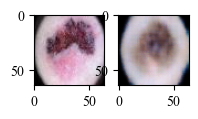

100%|██████████| 82/82 [00:07<00:00, 11.04it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/model-4/674fbc656d5849f2a080cb592dcf12be
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [4100] : (0.04590350389480591, 2.9348225593566895)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INFO:     Adam_epsilon     

In [21]:
### Training the DB-VAE on ISIC + ArGI ###
import IPython
# Hyperparameters
params = dict(
  batch_size = 32,
  learning_rate = 5e-4,
  latent_dim = 100,
  num_epochs = 50, #DB-VAE needs slightly more epochs to train
)

experiment = create_experiment("Model_4", params)

# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(params["latent_dim"])
optimizer = tf.keras.optimizers.Adam(params["learning_rate"])

@tf.function
def debiasing_train_step(x, y):

  with tf.GradientTape() as tape:
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)
    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
  grads = tape.gradient(loss, dbvae.trainable_variables)
  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss

all_imgs = loader_ISIC_ArGI.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

loss_history_2 = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
# The training loop -- outer loop iterates over the number of epochs
step = 0
for i in range(params["num_epochs"]):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, params["num_epochs"]))
  p_lesions = get_training_sample_probabilities(all_imgs, dbvae)

  for j in tqdm(range(loader_ISIC_ArGI.get_train_size() // params["batch_size"])):
    # load a batch of data
    (x, y) = loader_ISIC_ArGI.get_batch(params["batch_size"], p_pos=p_lesions)

    # loss optimization
    loss = debiasing_train_step(x, y)
    experiment.log_metric("loss", loss.numpy().mean(), step=step, epoch=i+1)
    loss_history_2.append(loss.numpy().mean())
    # plot the progress every 200 steps
    if j % 500 == 0:
      mdl.util.plot_sample(x, y, dbvae)

    step += 1

experiment.end()

In [22]:
### Obtain Loss Values Over Epoch ###
steps = len(loss_history_2.get())
print(steps)

epochs = np.uint8(params['num_epochs'])
batches_per_epoch = np.uint8(steps/epochs)

loss_hist = np.zeros((steps,1))
for i in range(steps):
    loss_hist[i] = loss_history_2.get()[i]
loss_hist = loss_hist.reshape(epochs, batches_per_epoch)

row_means = np.zeros((epochs))
for i in range(epochs):
    row_means[i] = loss_hist.sum(axis=1)[i]

row_means = row_means/batches_per_epoch
for mean in row_means:
    print(mean)

4100
0.941042896377355
0.7901047043078685
0.7035268580181467
0.6667671573110964
0.6397866249345056
0.603822557773788
0.5699259964549374
0.5442036210148958
0.5112367689290009
0.48458395230964124
0.4571939070616734
0.4346183064921056
0.40259318609353945
0.3843153870644707
0.35915414186122996
0.31363168907468864
0.2977657705969204
0.2822963310415379
0.2620203419632629
0.2373685286065789
0.22430440776280222
0.20177285414052037
0.18027921859545787
0.190900242082751
0.19236296959113372
0.17992772519591585
0.16337639934650922
0.15051902516083615
0.14244660950969157
0.13293792890865497
0.1281822010929755
0.1307758680725985
0.12883719794095802
0.12486721766026362
0.12275488879052904
0.110778545178307
0.12504175800363462
0.118737272334826
0.1075439847120134
0.11588883476139901
0.10794944169349988
0.0976224297793147
0.09769843578745055
0.09040433728623334
0.08111667391177269
0.09198056644094449
0.10054266424230764
0.11497134613715412
0.1095528919773102
0.10624418002360607


In [23]:
### Evaluation of standard CNN on ISIC ###
n=30
accuracies = np.zeros((n,1))

for i in range(n):
    (batch_x, batch_y) = loader_ISIC.get_batch(256) # Matches batch size
    y_pred_standard = tf.round(tf.nn.sigmoid(dbvae.predict(batch_x)))
    acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
    accuracies[i] = acc_standard.numpy()

print(accuracies.mean())
print(accuracies.std())

0.9298177083333333
0.014245172526901195


In [24]:
### Evaluation of standard CNN on ISIC_DiDI ###
n=30
accuracies = np.zeros((n,1))

for i in range(n):
    (batch_x, batch_y) = loader_ISIC_DiDI.get_batch(256) # Matches batch size
    y_pred_standard = tf.round(tf.nn.sigmoid(dbvae.predict(batch_x)))
    acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
    accuracies[i] = acc_standard.numpy()

print(accuracies.mean())
print(accuracies.std())

0.8201822916666667
0.023813890329235313
